# Analyzing IICW3C logs
python environment, functions, and examples
<br>
Sam Gartrell | 6/30/23
<br>

## environment
- use conda to clone the environment stored in `environment.yml`
    ```
    conda env create -f environment.yml
    conda activate iisw3c-tool
    ```

- if using this notebook, set the kernel to 'parse-iis'

- you will also need a .env file with credentials for the `geoip2` geocoder, represented as a key stored under `GEOAPI2_KEY` and an account id stored under `GEOIP2_AID`. you can set up a free account [here](maxmind.com/en/geoip2-databases). the .env should also contain `LOG_LOCATION`, representing a file path where logs (.log files) are stored in folders for each month.

In [4]:
import geopandas as gpd
from shapely.geometry import Point
import warnings
import numpy as np
import requests as r
import pprint
import time
import pandas as pd
warnings.simplefilter(
    action='ignore', category=pd.errors.SettingWithCopyWarning
    )
from geoip2 import webservice, errors
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
from user_agents import parse

if load_dotenv():
    print('env variables loaded')

logfile_location = os.getenv('LOG_LOCATION')

env variables loaded


## functions
Use these functions to access and analyze data stored in local log files. Recommend first developing analysis on a single log, then expanding it to target the month or set of months.

In [2]:
def log_to_df(
        log_path:str,
        fields:list=['date', 'time', 's-ip', 'cs-method', 'cs-uri-stem', 'cs-uri-query', 's-port', 'cs-username', 'c-ip', 'cs(User-Agent)', 'cs(Referer)', 'sc-status', 'sc-substatus', 'sc-win32-status', 'sc-bytes', 'time-taken']
        ):
    """
    loads a log file into a pandas dataframe
    """
    # Read the log file into a DataFrame
    df = pd.read_csv(log_path, sep=' ', header=None, names=fields, skiprows=4)

    # add a unique ID to dataframe so it can be cut into subsets
    df['uid'] = range(1, len(df) + 1)

    return df

def logs_to_df(
        folder_path:str,
        fields:list=['date', 'time', 's-ip', 'cs-method', 'cs-uri-stem', 'cs-uri-query', 's-port', 'cs-username', 'c-ip', 'cs(User-Agent)', 'cs(Referer)', 'sc-status', 'sc-substatus', 'sc-win32-status', 'sc-bytes', 'time-taken'],
        filter_mm_rlis=False):
    """
    loads a folder of log files into a single pandas dataframe. all log files must have the same fields, and follow the ISSW3C spec.
    """
    start = time.time()

    # initialize list for per-log dataframes, later flattened
    dfs = []

    # for each log file in the target folder,
    for file in os.listdir(folder_path):
        if file.endswith('.log'):
            print(f'\t\tloading {file} to dataframe')
            log = os.path.join(folder_path, file)
            
            # read it into a dataframe (ignore 1st 4 lines, in keeping with ISSW3C format)
            # add it to the list
            if filter_mm_rlis:
                df = filter_metromaps_rlis(
                    pd.read_csv(log, sep=' ', header=None, names=fields, skiprows=4)
                )
            else:
                df = pd.read_csv(log, sep=' ', header=None, names=fields, skiprows=4)

            dfs.append(df)
            # print(file, "read successfully")

    # flatten the list
    folder_df = pd.concat(dfs, axis=0, ignore_index=True)

    # add a unique ID to dataframe so it can be cut into subsets
    folder_df['uid'] = range(1, len(folder_df) + 1)


    print(f'took {time.time() - start} sec')
    return folder_df

def geocode_ip(dataframe: pd.DataFrame, sample_size: int = 100):
    """
    returns a geodataframe of points representing IP addresses from the dataframe passed.
    Works well with a df that's already grouped by IP address, to maximize the number of unique IPs sampled and geocoded.
    only 1000 requests/day are permitted; consider upgrading to a paid svc 
    """
    # geocoder api stuff
    key = os.getenv('GEOIP2_KEY') # api key
    aid = os.getenv('GEOIP2_AID') # acc id

    # get every nth record to reduce burden on geocoder
    subset = dataframe.sample(n=sample_size)
    subset['lat'] = ""
    subset['lon'] = ""
    subset['reserved_ip'] = False

    # for each row, geocode its ip
    with webservice.Client(aid, key, host='geolite.info') as client:
        for row_index, row in subset.iterrows():
            try:
                response = client.city(row['c-ip'])
                lon = response.location.longitude
                lat = response.location.latitude
                subset.loc[row_index, ['lon', 'lat']] = [lon, lat]
            except errors.AddressNotFoundError:
                subset.loc[row_index, 'reserved_ip'] = True

    spatial_subset = subset[subset['reserved_ip'] == False]
    geo = [
        Point(lon, lat) for
            lon, lat in 
                zip(
                    spatial_subset['lon'],
                    spatial_subset['lat']
                )]
    
    return gpd.GeoDataFrame(spatial_subset, geometry=geo)


def parse_user_agent(user_agent):
    ua = parse(user_agent)
    
    device = {
        'brand': ua.device.brand,
        'model': ua.device.model,
        'os': f'{ua.os.family} {ua.os.version_string}'
    }
    
    browser = {
        'family': ua.browser.family,
        'version': ua.browser.version_string
    }
    
    is_bot = any(keyword in user_agent.lower() for keyword in ['bot', 'crawler', 'spider'])
    
    return {
        'agent_str': user_agent,
        'device': device,
        'browser': browser,
        'is_bot': is_bot
    }


def batch_stats(function, log_dir=fr'{logfile_location}', just_mm_rlis=False):
    """
    iteratively applies a stats function to every month in the log folder, reporting results
    """

    for i in os.listdir(log_dir):
        print(i)
        if i.endswith('.zip') or i.endswith('.txt'):
            pass
        else:
            # make the log for the month
            month = logs_to_df(os.path.join(log_dir, i), filter_mm_rlis=just_mm_rlis)

            # get and view ip stats
            stats = function(month)
            print(
                i.split('/')[-1],
                pprint.pformat(stats)
            )
            month = None
            print('__________________________________________')

def ip_request_statistics(dataframe:pd.DataFrame, use_log=True):
    """
    computes mean, standard deviation of request counts by IP,
    and gives z-score of most prolific IP (base-2 logarithm-transformed if use_log==True),
    for the dataframe passed
    """
    # Calculate the request count per IP address (log-transformed)
    request_counts = dataframe['c-ip'].value_counts()
    if use_log:
        request_counts = np.log2(
            request_counts
        )
        

    # Calculate the mean and standard deviation of request counts
    mean_requests = request_counts.mean()
    std_requests = request_counts.std()

    # Identify the most prolific IP address
    most_prolific_ip = request_counts.idxmax()

    # Calculate the z-score for the most prolific IP address
    z_score = (request_counts[most_prolific_ip] - mean_requests) / std_requests

    return {
        # the mean number of requests coming from a single IP
        'mean_request_count': mean_requests,

        # the dispersion of the above
        'stdev_request_count': std_requests,

        # top 10 most prolific IP addresses
        'top_10': list(dataframe['c-ip'].value_counts().head(10).index),

        # the number of unique IP addresses
        'n_unique': dataframe['c-ip'].nunique(),

        # address, request count, and z-score (prominence) of most prolific IP in the dataframe
        'top': {
            'address': most_prolific_ip,
            'request_count': request_counts.max(),
            'z_score': z_score
        },

        # wether or not these statistics come from logarithm-transformed data
        'used_log': use_log
    }

def filter_services(dataframe):
    '''
    metro-specific: get insights on /services/ endpoints that aren't from ArcGIS rest and are referred froim metromaps referrers
    '''
    return dataframe[
    (dataframe['cs(Referer)'].str.contains('metromap')) &
    (dataframe['cs-uri-stem'].str.contains('/services/')) &
    (~dataframe['cs-uri-stem'].str.contains('/ArcGIS/')) &
    (~dataframe['cs-uri-stem'].str.contains('/arcgis/'))
    ]

def parse_uri_stem(row):
    '''
    used in append_uri_path to break apart URI stem into a list, given a series with appropriate stem field'''
    path = row['cs-uri-stem']
    if pd.isnull(path):
        return [None, None, None, None]
    else:
        split_values = path.split('/')
        if len(split_values) >= 5:
            return split_values[:5]
        else:
            split_values += [None] * (5 - len(split_values))
            return split_values
        
def append_uri_path(dataframe):
    '''
    appends first 5 elements of a uri stem as separate fields to the end of a dataframe, for each row
    '''

    # Apply parse_uri_stem function to 'cs-uri-stem' column and store the results
    split_values = dataframe.apply(parse_uri_stem, axis=1)

    # Create new columns for the first five values in the split_values DataFrame
    dataframe['1st_value'] = split_values.apply(lambda x: x[0])
    dataframe['2nd_value'] = split_values.apply(lambda x: x[1])
    dataframe['3rd_value'] = split_values.apply(lambda x: x[2])
    dataframe['4th_value'] = split_values.apply(lambda x: x[3])
    dataframe['5th_value'] = split_values.apply(lambda x: x[4])
    
    return dataframe

def filter_metromaps_rlis(dataframe):
    return dataframe[
    (dataframe['cs-uri-stem'].str.contains('rlisapi')) & (dataframe['cs(Referer)'].str.contains('metromap'))
    ]

def user_agent_statistics(dataframe:pd.DataFrame, use_log:bool=True):
    """
    looks at the distribution and characteristics of User Agent info,
    and gives z-score of most prolific IP (base-2 logarithm-transformed if use_log)
    """
    # Calculate the request count per IP address (log-transformed)
    user_agent_counts = dataframe['cs(User-Agent)'].value_counts()
    # print('user agent counts\n', user_agent_counts)
    if use_log:
        user_agent_counts = np.log2(
            user_agent_counts
        )
        

    # calculate the average number of requests associated with a distinct user agent
    mean_requests = user_agent_counts.mean()

    # get dispersion of that statistic via stdev
    std_requests = user_agent_counts.std()

    # Identify the most common user agent (TODO: generalize by browser or ???)
    most_prolific_ua = user_agent_counts.idxmax()

    # Calculate the z-score for the most common user agent
    z_score = (user_agent_counts[most_prolific_ua] - mean_requests) / std_requests

    # check for suspish user agent strings
    top10 = []
    for agent in list(user_agent_counts.head(10).index):
        top10.append(parse_user_agent(agent))

    return {
        # average number of requests associated with a distinct user agent
        'mean_request_count': mean_requests,

        # dispersion of that statistic via stdev
        'stdev_request_count': std_requests,

        # top 10 user agents
        'top_10': top10,
        'n_unique': dataframe['c-ip'].nunique(),
        'top': {
            'user_agent': most_prolific_ua,
            'request_count': user_agent_counts.max(),
            'z_score': z_score
        },
        'used_log': use_log
    }

def check_svc_layer(dataframe):

    svcs = filter_services(dataframe)
    svcs_parsed = append_uri_path(svcs)

    return {
        '3rd value counts': svcs_parsed['3rd_value'].value_counts(),
        '4th value counts': svcs_parsed['4th_value'].value_counts()
    }

NameError: name 'pd' is not defined

## examples

### example: view and visualize request statistics by IP in a log file

In [3]:
# load log file for a given day
oct4 = log_to_df(os.path.join(logfile_location, '202210/u_ex221004.log'))

# get and view IP statistics (logarithm-transformed)
stats = ip_request_statistics(oct4)
print(
    pprint.pformat(stats)
)

{'mean_request_count': 3.493246446838121,
 'n_unique': 3803,
 'stdev_request_count': 2.563869950055888,
 'top': {'address': '52.205.137.89',
         'request_count': 14.928287036957299,
         'z_score': 4.460070445410039},
 'top_10': ['52.205.137.89',
            '34.234.176.30',
            '34.233.233.138',
            '208.71.202.129',
            '204.147.152.14',
            '204.147.152.5',
            '10.80.101.81',
            '67.160.140.19',
            '10.80.101.208',
            '205.173.217.10'],
 'used_log': True}


In [4]:
# filter to show instances of the RLIS api  being targeted by metromaps referrers
oc4_mm = oct4[
    (oct4['cs-uri-stem'].str.contains('rlisapi')) & (oct4['cs(Referer)'].str.contains('metromap'))
    ]
oc4_mm['cs-uri-stem']



3581                 /rlisapi2/js/
5126                 /rlisapi2/js/
5321      /rlisapi2/GetSuggestion/
5322      /rlisapi2/GetSuggestion/
5323      /rlisapi2/GetSuggestion/
                    ...           
541566       /rlisapi2/QueryPoint/
541596     /rlisapi2/queryAddress/
542019     /rlisapi2/queryAddress/
542227     /rlisapi2/queryAddress/
547138               /rlisapi2/js/
Name: cs-uri-stem, Length: 8553, dtype: object

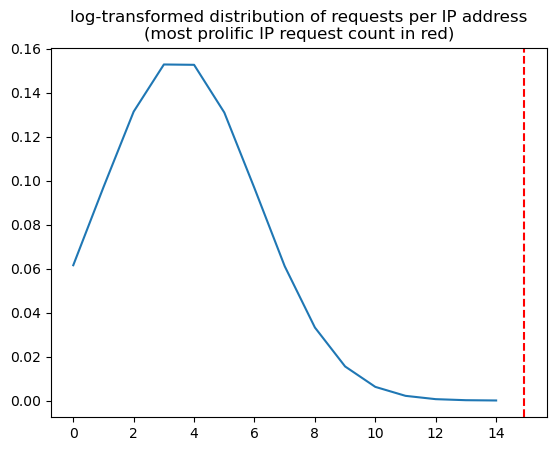

In [5]:
# get a a depiction of how prominent the most popular IP address is
# visualize the distribution of requests per IP, using numpy and matplotlib
x_axis = np.arange(
    0,
    stats['top']['request_count']
)

plt.plot(
    x_axis,
    norm.pdf(x_axis, stats['mean_request_count'],
             stats['stdev_request_count'])
)

plt.title('log-transformed distribution of requests per IP address\n(most prolific IP request count in red)')

# add most prolific IP as a red line
plt.axvline(x=stats['top']['request_count'], color='r', linestyle='--')

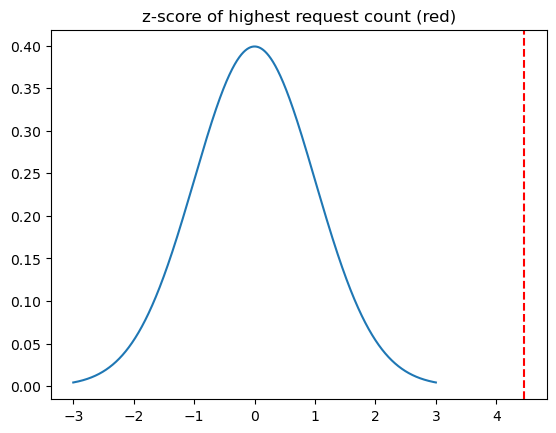

In [6]:
# standardize the distribution to look at z-score
x_axis = np.arange(-3, 3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.title('z-score of highest request count (red)')

# adding z-score, in this case to a similar effect
plt.axvline(x=stats['top']['z_score'], color='r', linestyle='--')

### example: view geographic distribution of users

C:\Users\sgartrel\AppData\Local\Temp\ipykernel_20408\447517926.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


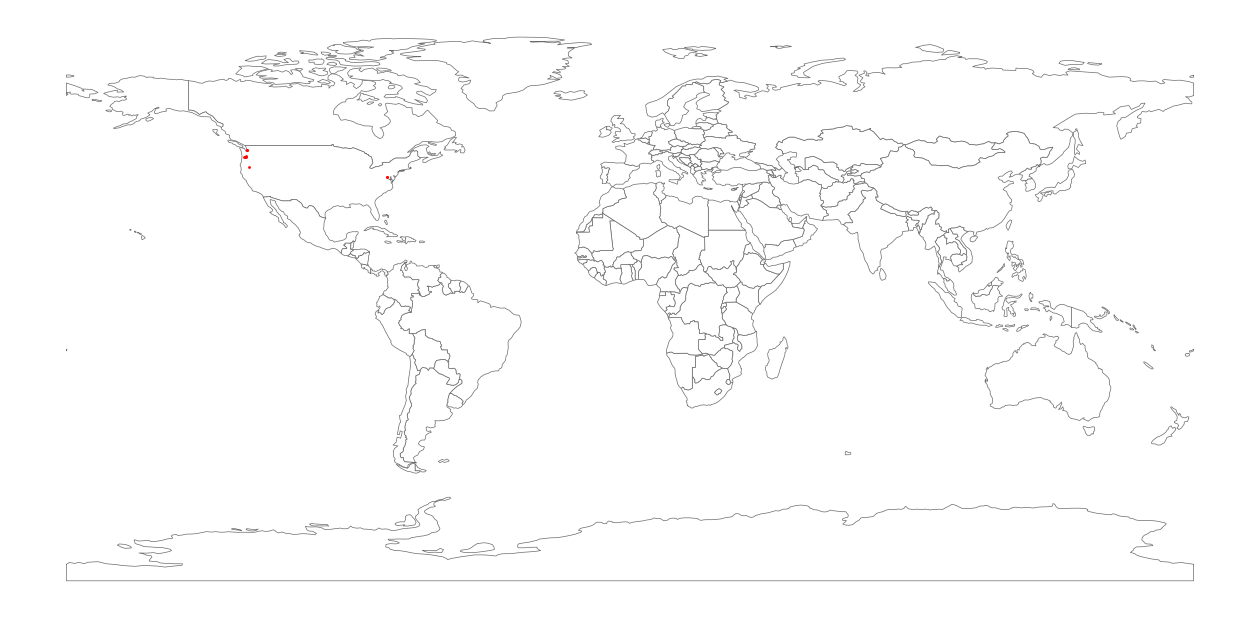

In [7]:
# geocode a subset of requests in the IIS log dataframe
# (NOTE: current geoip2 plan only allows 1000 request per day)
oct4_geocoded = geocode_ip(oct4, sample_size=10)
fig, ax = plt.subplots(figsize=(16, 16))

# fyi this dataset was deprecated 2023
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot(ax=ax, color='#ffffff', edgecolor='#6a6a6a', linewidth=.5)
oct4_geocoded.plot(ax=ax, color='red', markersize=1)
_=ax.axis('off')

# Show the plot
plt.show()

In [ ]:
batch_stats(check_svc_layer)

In [13]:
# trim down to metromap referrer, run again
check_svc_layer(logs_to_df(r'd:/metro/logs/202304/'))


		loading u_ex230401.log to dataframe
		loading u_ex230402.log to dataframe
		loading u_ex230403.log to dataframe
		loading u_ex230404.log to dataframe
		loading u_ex230405.log to dataframe
		loading u_ex230406.log to dataframe
		loading u_ex230407.log to dataframe
		loading u_ex230408.log to dataframe
		loading u_ex230409.log to dataframe
		loading u_ex230410.log to dataframe
		loading u_ex230411.log to dataframe
		loading u_ex230412.log to dataframe
		loading u_ex230413.log to dataframe
		loading u_ex230414.log to dataframe
		loading u_ex230415.log to dataframe
		loading u_ex230416.log to dataframe
		loading u_ex230417.log to dataframe
		loading u_ex230418.log to dataframe
		loading u_ex230419.log to dataframe
		loading u_ex230420.log to dataframe
		loading u_ex230421.log to dataframe
		loading u_ex230422.log to dataframe
		loading u_ex230423.log to dataframe
		loading u_ex230424.log to dataframe
		loading u_ex230425.log to dataframe
		loading u_ex230426.log to dataframe
		loading u_

{'3rd value counts': 3rd_value
 taxlots                      6146
 2ftcontours                  4715
 metrobounds                  1826
 Land                         1252
 cityBounds                    786
 floodPlain                    777
 ugb                           748
 wetlands                      708
 Slope25                       602
 ORCA_ParksAndNaturalAreas     577
 reserves                      423
 uplandHabitat                 403
 Slope10                       388
 riparianHabitat               369
 vacantlands2013               283
 ORCA_Schools                  273
 ORCA_Cemeteries               247
 voterPrecincts                220
 Zoning                        174
 trailsExisting                122
 councilDistrict               120
 ORCA_HOAs                     116
 Sectionlines                  116
 neighborhoods                 113
 waterDistrict                  88
 schoolDistricts                70
 fireDistricts                  32
 ORCA_GolfCourses       

In [ ]:
# get metromaps/rlis specific df
# This takes about an hour to run for a single month. APpending UA info to dataframe isn't time-effective
df = logs_to_df(r'd:/metro/logs/202211')

# df = df.head(10)

# apply the parse user agent func and ascribe is_bot, browser, os fields to dataframe
df[['is_bot']] = df['cs(User-Agent)'].apply(lambda x: pd.Series(parse_user_agent(x)['is_bot']))
df[['os']] = df['cs(User-Agent)'].apply(lambda x: pd.Series(parse_user_agent(x)['device']['os']))
df[['browser']] = df['cs(User-Agent)'].apply(lambda x: pd.Series(parse_user_agent(x)['browser']['family']))

# check value counts

In [ ]:
print(len(df))

print(df['is_bot'].value_counts())
print(df['browser'].value_counts())
print(df['os'].value_counts())

In [ ]:
# get metromaps/rlis specific df
df = logs_to_df(r'd:/metro/logs/202211', filter_mm_rlis=True)

# df = df.head(10)

# apply the parse user agent func and ascribe is_bot, browser, os fields to dataframe
df[['is_bot']] = df['cs(User-Agent)'].apply(lambda x: pd.Series(parse_user_agent(x)['is_bot']))
df[['os']] = df['cs(User-Agent)'].apply(lambda x: pd.Series(parse_user_agent(x)['device']['os']))
df[['browser']] = df['cs(User-Agent)'].apply(lambda x: pd.Series(parse_user_agent(x)['browser']['family']))

# check value counts

### example: get average number of hits for each unique URI prefix


In [24]:
# read through csv of common uri-stem prefixes, 
# get the average number of hits for each prefix
folder_path = r'd:/metro/scripts/IISW3C-parse-tools/ua-by-uri/'

dataframes = []

# Read each CSV file and create dataframes
for filename in os.listdir(folder_path):
    print(filename)
    if filename.endswith('.CSV'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, names=['Hits', 'Prefix'], skiprows=1)
        dataframes.append(df)

merged_df = pd.concat(dataframes).groupby('Prefix').mean().reset_index()

final = merged_df[merged_df['Hits'] > 10]

# if it's /services/% you're after
services = merged_df[
    (merged_df['Prefix'].str.contains('/services/')) &
    ~(merged_df['Prefix'].str.contains('ArcGIS')) &
    ~(merged_df['Prefix'].str.contains('arcgis'))
    ]

out = services.sort_values('Hits', ascending=False).reset_index()

out.to_csv('avg_hits_per_2prefix.csv', index=False)

2210_trunks_activity.CSV
2211_trunks_activity.CSV
2212_trunks_activity.CSV
2301_trunks_activity.CSV
2302_trunks_activity.CSV
2303_trunks_activity.CSV
2304_trunks_activity.CSV


In [44]:
# view most common browser for major URI prefixes
log_data = log_to_df(r'd:/metro/logs/202210/u_ex221004.log')
log_data = log_data[log_data['cs(Referer)'].str.contains('metromap')]
# list of 2-folder URI prefixes
prefixes = ['/rlisapi2/getsuggestion', '/arcgis/rest', '/metromap/img', '/rlisapi2/queryaddress', '/rlisapi2/js', '/assets/img', '/assets/fonts', '/metromap/js', '/services/taxlots', '/metromap/fonts', '/metromap/css', '/services/2ftcontours', '/rlisapi2/querypoint', '/services/citybounds', '/services/land', '/services/metrobounds', '/services/slope25', '/services/wetlands', '/services/riparianhabitat', '/services/floodplain', '/services/ugb', '/metromap/printserver.ashx', '/services/orca_parksandnaturalareas', '/services/slope10', '/services/sewerdistricts', '/services/uplandhabitat', '/services/reserves', '/authentication/js', '/services/haulers', '/metromap/print', '/services/boundary', '/services/vacantlands2013',
            '/services/neighborhoods', '/services/councildistrict', '/services/trailsexisting', '/services/firedistricts', '/services/schooldistricts', '/services/waterdistrict', '/services/sectionlines', '/rlisapi2/searchtaxlotid', '/favicon.ico', '/services/zoning', '/services/orca_schools', '/services/transitdistrict', '/services/voterprecincts', '/services/lrt', '/services/orca_cemeteries', '/services/multifamily', '/services/orca_hoas', '/services/parkdistricts', '/services/orca_other', '/services/censustracts', '/metromap/', '/metromap/help.htm', '/services/orca_golfcourses', '/authentication/', '/metromap/embed', '/metromap/feedback.ashx', '/rlisapi2/searchtaxlotowner', '/historic_photo_viewer']

for p in prefixes:
    df = log_data[log_data['cs-uri-stem'].str.startswith(p)]
    if len(df) > 0:
        print(f'\n\n___{p} USER AGENT INFO___\n')
        pprint.pprint(user_agent_statistics(df))
        print('____________________________________________')



___/arcgis/rest USER AGENT INFO___

{'mean_request_count': 2.4921827213047814,
 'n_unique': 157,
 'stdev_request_count': 2.442736831338038,
 'top': {'request_count': 8.092757140919852,
         'user_agent': 'Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/105.0.0.0+Safari/537.36',
         'z_score': 2.292745721833363},
 'top_10': [{'agent_str': 'Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/105.0.0.0+Safari/537.36',
             'browser': {'family': 'Chrome', 'version': '105.0.0'},
             'device': {'brand': None, 'model': None, 'os': 'Windows '},
             'is_bot': False},
            {'agent_str': 'Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/106.0.0.0+Safari/537.36',
             'browser': {'family': 'Chrome', 'version': '106.0.0'},
             'device': {'brand': None, 'model': None, 'os': 'Windows '},
             'is_bot': False},
         

### example: view layers at /services/ referred by metromap, ranked by usage

In [51]:
def mm_referred_gislayers(df):
    svcs = df[
    (df['cs-uri-stem'].str.startswith('/services/')) &
    (df['cs(Referer)'].str.contains('metromap'))
    ]
    svcs_no_arc = svcs[
    ~(svcs['cs(Referer)'].str.contains('ArcGIS')) &
    ~(svcs['cs(Referer)'].str.contains('arcgis'))
    ]
    svcs_parsed = append_uri_path(svcs)
    svcs_no_arc_parsed = append_uri_path(svcs_no_arc)
    print('incl. arcgis referrers:\n', svcs_parsed.value_counts(['3rd_value']), '\n\n')
    print('not incl. arcgis referrers:\n', svcs_no_arc_parsed.value_counts(['3rd_value']), '\n\n')

batch_stats(mm_referred_gislayers)


202210.zip
202211.zip
202302.zip
202303.zip
202304.zip
drive-download-20230623T201911Z-001.zip
202210
		loading u_ex221001.log to dataframe
		loading u_ex221002.log to dataframe
		loading u_ex221003.log to dataframe
		loading u_ex221004.log to dataframe
		loading u_ex221005.log to dataframe
		loading u_ex221006.log to dataframe
		loading u_ex221007.log to dataframe
		loading u_ex221008.log to dataframe
		loading u_ex221009.log to dataframe
		loading u_ex221010.log to dataframe
		loading u_ex221011.log to dataframe
		loading u_ex221012.log to dataframe
		loading u_ex221013.log to dataframe
		loading u_ex221014.log to dataframe
		loading u_ex221015.log to dataframe
		loading u_ex221016.log to dataframe
		loading u_ex221017.log to dataframe
		loading u_ex221018.log to dataframe
		loading u_ex221019.log to dataframe
		loading u_ex221020.log to dataframe
		loading u_ex221021.log to dataframe
		loading u_ex221022.log to dataframe
		loading u_ex221023.log to dataframe
		loading u_ex221024.log

KeyboardInterrupt: 

### example: simple user agent breakdown
we want a nice pie chart where metro can see proportional use of each browser and each OS

In [5]:
# function to append browser to each request
def extract_browser(user_agent):
    parsed_agent = parse(user_agent)
    return parsed_agent.browser.family


# function to append os to each request
def extract_os(user_agent):
    parsed_agent = parse(user_agent)
    return parsed_agent.os.family

log = log_to_df(r'd:/metro/logs/202211/u_ex221112.log')

log['browser'] = log['cs(User-Agent)'].apply(extract_browser)
log['os'] = log['cs(User-Agent)'].apply(extract_os)



most popular browser: browser                   
Chrome                        77934
Other                         28385
Mobile Safari                 21144
Safari                        19367
Firefox                        9471
Edge                           6973
Chrome Mobile iOS              3833
Electron                       2993
Mobile Safari UI/WKWebView     1940
SemrushBot                     1495
bingbot                        1203
BingPreview                     756
IE                              567
Googlebot                       511
Samsung Internet                488
Firefox Mobile                  405
DuckDuckGo Mobile               392
Firefox iOS                     303
AhrefsBot                       296
axios                           237
Apache-HttpClient               224
Edge Mobile                     136
Opera                           130
Python Requests                 127
Chrome Mobile WebView            87
Snapchat                         66
Googlebot-Image

In [40]:
bots = log[
    log['browser'].str.contains('bot') |
    log['browser'].str.contains('Bot') |
    log['browser'].str.contains('Peeker') |
    log['browser'].str.contains('Crawler') |
    log['browser'].str.contains('Spider') |
    ]
mobile_browsers = log[
    log['browser'].str.contains('mobile') |
    log['browser'].str.contains('Mobile') |
    log['browser'].str.contains('Snapchat') |
    log['browser'].str.contains('Instagram')
    ]
top_browsers = log.value_counts(['browser']).head(10)
top_oss = log.value_counts(['os']).head(10)


top_browsers['Other'] += len(log) - sum(top_browsers)
top_oss['Other'] += len(log) - sum(top_oss)

print('most popular browsers:', top_browsers)
print('most popular oss:', top_oss)
print()
print('bot count:', len(bots))
print('bot proportion:', len(bots)/len(log))

print('mobile browser count:', len(mobile_browsers))
print('mobile browser proportion:', len(mobile_browsers)/len(log))

most popular browsers: browser                   
Chrome                        77934
Other                         28385
Mobile Safari                 21144
Safari                        19367
Firefox                        9471
Edge                           6973
Chrome Mobile iOS              3833
Electron                       2993
Mobile Safari UI/WKWebView     1940
SemrushBot                     1495
bingbot                        1203
BingPreview                     756
IE                              567
Googlebot                       511
Samsung Internet                488
Firefox Mobile                  405
DuckDuckGo Mobile               392
Firefox iOS                     303
AhrefsBot                       296
axios                           237
Apache-HttpClient               224
Edge Mobile                     136
Opera                           130
Python Requests                 127
Chrome Mobile WebView            87
Snapchat                         66
Googlebot-Imag

In [39]:

top_browsers

browser      
Chrome           77934
Other            51962
Mobile Safari    21144
Safari           19367
Firefox           9471
Name: count, dtype: int64